In [1]:
import os, sys
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import shutil
import glob
import time
import argparse
import json
from easydict import EasyDict
import copy
import pprint
from collections import namedtuple

import math
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchcontrib
import torch.backends.cudnn as cudnn

import fastai
from fastai.basic_data import DataBunch
# from fastai.vision import Learner
from modules.blend_data_augmentation import Learner
from fastai.distributed import setup_distrib, num_distrib

from tqdm import tqdm
from functools import partial

import models.model_list as model_list
from modules.adabound import AdaBound
from modules.ranger913A import Ranger
from modules.train_annealing import fit_with_annealing
import modules.swa as swa
from utils.dataloader import get_data_loaders, get_fastai_data_bunch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils.losses import MosLoss
from utils.metrics import accuracy, macro_f1, genus_accuracy, species_accuracy,\
                            genus_f1_score, species_f1_score
from utils.misc import log_metrics, cosine_annealing_lr
from utils.callbacks import SaveBestModel, WandbCallback
from utils.vis_utils import plttensor

# from utils.logger import Logger as TfLogger
# from tensorboardX import SummaryWriter
import wandb

from configs.config import config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    cudnn.benchmark = True

if not os.path.exists('./configs/old_configs/'+config.exp_name):
    os.makedirs('./configs/old_configs/'+config.exp_name)
shutil.copy2('./configs/config.py', './configs/old_configs/{}/config.py'
                    .format(config.exp_name))

if not os.path.exists('./model_weights/'+config.exp_name):
    os.makedirs('./model_weights/'+config.exp_name)
if not os.path.exists('./subm/'+config.exp_name):
    os.makedirs('./subm/'+config.exp_name) 
    
args = EasyDict()
args.dev_mode = False
args.resume = False
args.latest = False
args.realtime = False

pprint.pprint(config)
%matplotlib inline

{'DATA_CSV_PATH': 'data/finale/datasplit_fold5big.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_atlanticus'),
               (3, 'aedes aedes_canadensis'),
               (4, 'aedes aedes_dorsalis'),
               (5, 'aedes aedes_flavescens'),
               (6, 'aedes aedes_infirmatus'),
               (7, 'aedes aedes_japonicus'),
               (8, 'aedes aedes_nigromaculis'),
               (9, 'aedes aedes_sollicitans'),
               (10, 'aedes aedes_taeniorhynchus'),
               (11, 'aedes aedes_triseriatus

In [3]:
pwd

'/home/vectech1/Documents/repos/novel-species-detection'

In [4]:
def get_class_map(df):
    class_map = {}
    for i in range(len(df)):
        class_map[df.loc[i, 'Species']] = df.loc[i, 'Species_Name']
    return class_map

In [5]:
cm = get_class_map(pd.read_csv('./data/finale/datasplit_fold1big.csv'))
for i in range(len(cm)):
    print(i, ": ", cm[i])
print(len(cm))

0 :  aedes_aegypti
1 :  aedes_albopictus
2 :  aedes_atlanticus
3 :  aedes_canadensis
4 :  aedes_dorsalis
5 :  aedes_flavescens
6 :  aedes_infirmatus
7 :  aedes_japonicus
8 :  aedes_nigromaculis
9 :  aedes_sollicitans
10 :  aedes_taeniorhynchus
11 :  aedes_triseriatus
12 :  aedes_trivittatus
13 :  aedes_vexans
14 :  anopheles_coustani
15 :  anopheles_crucians
16 :  anopheles_freeborni
17 :  anopheles_funestus
18 :  anopheles_gambiae
19 :  anopheles_pseudopunctipennis
20 :  anopheles_punctipennis
21 :  anopheles_quadrimaculatus
22 :  coquillettidia_perturbans
23 :  culex_coronator
24 :  culex_erraticus
25 :  culex_nigripalpus
26 :  culex_pipiens_sl
27 :  culex_restuans
28 :  culex_salinarius
29 :  culiseta_incidens
30 :  culiseta_inornata
31 :  deinocerites_cancer
32 :  deinocerites_cuba-1
33 :  mansonia_titillans
34 :  psorophora_ciliata
35 :  psorophora_columbiae
36 :  psorophora_cyanescens
37 :  psorophora_ferox
38 :  psorophora_pygmaea
39 :  aedes_spp
40 :  anopheles_spp
41 :  culex_

In [6]:
model_params = [config.exp_name, config.model_name]
MODEL_CKPT = os.path.abspath('./model_weights/{}/best_{}.pth'.format(*model_params))

Net = getattr(model_list, config.model_name)

net = Net(config=config)

gpu = setup_distrib(config.gpu)
opt = config.optimizer
mom = config.mom
alpha = config.alpha
eps = config.eps

if   opt=='adam': opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
elif opt=='adamw': opt_func = partial(optim.AdamW, betas=(mom,alpha), eps=eps)
elif opt=='radam': opt_func = partial(RAdam, betas=(mom,alpha), eps=eps)
elif opt=='novograd': opt_func = partial(Novograd, betas=(mom,alpha), eps=eps)
elif opt=='rms': opt_func = partial(optim.RMSprop, alpha=alpha, eps=eps)
elif opt=='sgd': opt_func = partial(optim.SGD, momentum=mom)
elif opt=='rangervar': opt_func = partial(RangerVar,  betas=(mom,alpha), eps=eps)
elif opt=='ranger': opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
elif opt=='ralamb': opt_func = partial(Ralamb,  betas=(mom,alpha), eps=eps)
elif opt=='over9000': opt_func = partial(Over9000,  k=12, betas=(mom,alpha), eps=eps)
elif opt=='lookahead': opt_func = partial(LookaheadAdam, betas=(mom,alpha), eps=eps)
elif opt=='Adams': opt_func=partial(Adams)
elif opt=='rangernovo': opt_func=partial(RangerNovo)
elif opt=='rangerlars': opt_func=partial(RangerLars)

else:
    raise ValueError("Optimizer not recognized")
        
train_ds, valid_ds = get_data_loaders(config, get_dataset=True, one_hot_labels=config.one_hot_labels)
print("Train dataset size = {}".format(len(train_ds)))
data = DataBunch.create(train_ds, valid_ds, bs=config.batch_size,
                         num_workers=config.num_workers)
loss = MosLoss(config=config)

freeze_bn = False
save_imgs = False
train_losses = []
valid_losses = []
valid_f1s = []
lr_hist = []

# callback_fns=[WandbCallback] if (config.wandb and not get_learn) else []

print('Training ...')
print('Saving to ', MODEL_CKPT)
metrics = [partial(accuracy, one_hot_labels=config.one_hot_labels), partial(macro_f1, one_hot_labels=config.one_hot_labels)]

Using Xception with 39 classes
Loading pretrained weights...
Reading data split from data/finale/datasplit_fold5big.csv
Data Augmemtation with probability  0.001
Train dataset size = 8729
Focal Loss with gamma =  0
Training ...
Saving to  /home/vectech1/Documents/repos/novel-species-detection/model_weights/bigset/fold5big/best_xception.pth


In [7]:
learn = (Learner(data, net, wd=config.weight_decay, opt_func=opt_func,
         metrics=metrics,
         bn_wd=False, true_wd=True,
         loss_func = loss,
         # loss_func = LabelSmoothingCrossEntropy(),
#          callback_fns=callback_fns,
         model_dir=MODEL_CKPT)
        )

if gpu is None: learn.to_parallel()
elif num_distrib()>1: learn.to_distributed(gpu)

best_save_cb = SaveBestModel(learn, config=config)    

In [8]:
learn.fit_one_cycle(60, config.lr, div_factor=10, pct_start=0.3, callbacks=[best_save_cb])       

epoch,train_loss,valid_loss,accuracy,macro_f1,time
0,2.690294,2.322503,0.583070,0.388626,01:43
1,1.854944,1.697815,0.688749,0.491938,01:38
2,1.488976,1.192490,0.779180,0.582558,01:38
3,1.263834,1.058892,0.821767,0.629338,01:39
4,1.083204,0.972491,0.844900,0.634085,01:39
5,0.993399,1.008536,0.843849,0.622442,01:39
6,0.835776,1.848151,0.696109,0.417043,01:40
7,0.868037,1.296315,0.782334,0.592328,01:40
8,0.847185,1.029469,0.831230,0.612436,01:40
9,0.809909,0.969236,0.855941,0.631675,01:40


## Test

In [9]:
%run test.py --metric acc --tta 1


{'DATA_CSV_PATH': 'data/finale/datasplit_fold5big.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_atlanticus'),
               (3, 'aedes aedes_canadensis'),
               (4, 'aedes aedes_dorsalis'),
               (5, 'aedes aedes_flavescens'),
               (6, 'aedes aedes_infirmatus'),
               (7, 'aedes aedes_japonicus'),
               (8, 'aedes aedes_nigromaculis'),
               (9, 'aedes aedes_sollicitans'),
               (10, 'aedes aedes_taeniorhynchus'),
               (11, 'aedes aedes_triseriatu

## Plots

In [10]:
subm = pd.read_csv('./subm/{}/best_acc.csv'.format(config.exp_name))
(subm['Species'] == subm['SpeciesPred']).sum()/len(subm)

0.9258474576271186

In [11]:
def plot_pretty_blue_confusion_matrix(y_true, y_pred, classes,
                                      normalize=False,
                                      title=None,
                                      cmap=plt.cm.Blues,
                                      savepath=None,
                                      figsize=(48,48)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    precisions = np.diag(cm) / np.sum(cm, axis = 0)
    recalls = np.diag(cm) / np.sum(cm, axis = 1)
    print("Precision: ", np.round(precisions, 4))
    print("Recall: ", np.round(recalls, 4))

    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix")

    # print(cm)
    save_df = pd.DataFrame(data=cm, columns=classes)
    save_df.index = classes
    if savepath is not None:
        save_df.to_csv(savepath.replace(savepath.split('/')[-1],'confusion.csv'), index=True)
    else:
        save_df.to_csv('./subm/confusion.csv', index=True)

    fig, ax = plt.subplots(figsize=figsize)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(fontsize=round(figsize[0]*.3))
    plt.yticks(fontsize=round(figsize[0]*.3))
    ax.set_xlabel('True label',fontsize=round(figsize[0]*.5))
    ax.set_ylabel('Predicted label',fontsize=round(figsize[0]*.5))
    plt.title(label=title,fontsize=round(figsize[0]*.75))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # ax.tick_params(direction='out', length=6, width=2, colors='r',
    #            grid_color='r', grid_alpha=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.25)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if math.isnan(val):
                val = 0.0
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center", size=round(figsize[0]*.35),
                    color="white" if cm[i, j] > thresh else "black")
    if savepath is not None:
        fig.savefig(savepath)
    return ax

/home/vectech1/anaconda3/envs/novelty_detection/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Precision:  [1.     0.9688 0.5294 0.8889 0.9545 0.9286 1.     0.9934 0.8333 1.     0.9231 0.7333 1.     0.8421 1.     0.9839 0.9462
 0.8764 0.9719 1.     0.8108 0.9655 1.     0.875  0.6724    nan 0.9009 0.     0.55      nan 1.     0.6    0.9333 1.
 1.     1.     0.9322 0.8857 1.    ]
Recall:  [1.     0.9789 0.6    0.8    0.9767 0.9286 1.     1.     1.     0.9833 0.96   0.8462 1.     0.96   1.     0.9839 0.9888
 0.9689 0.8918 0.4444 0.9375 0.8    0.9714 0.7    0.78   0.     0.9676 0.     0.4583 0.     1.     0.6667 0.9333 0.8462
 0.9643 1.     1.     0.9118 1.    ]
Normalized confusion matrix


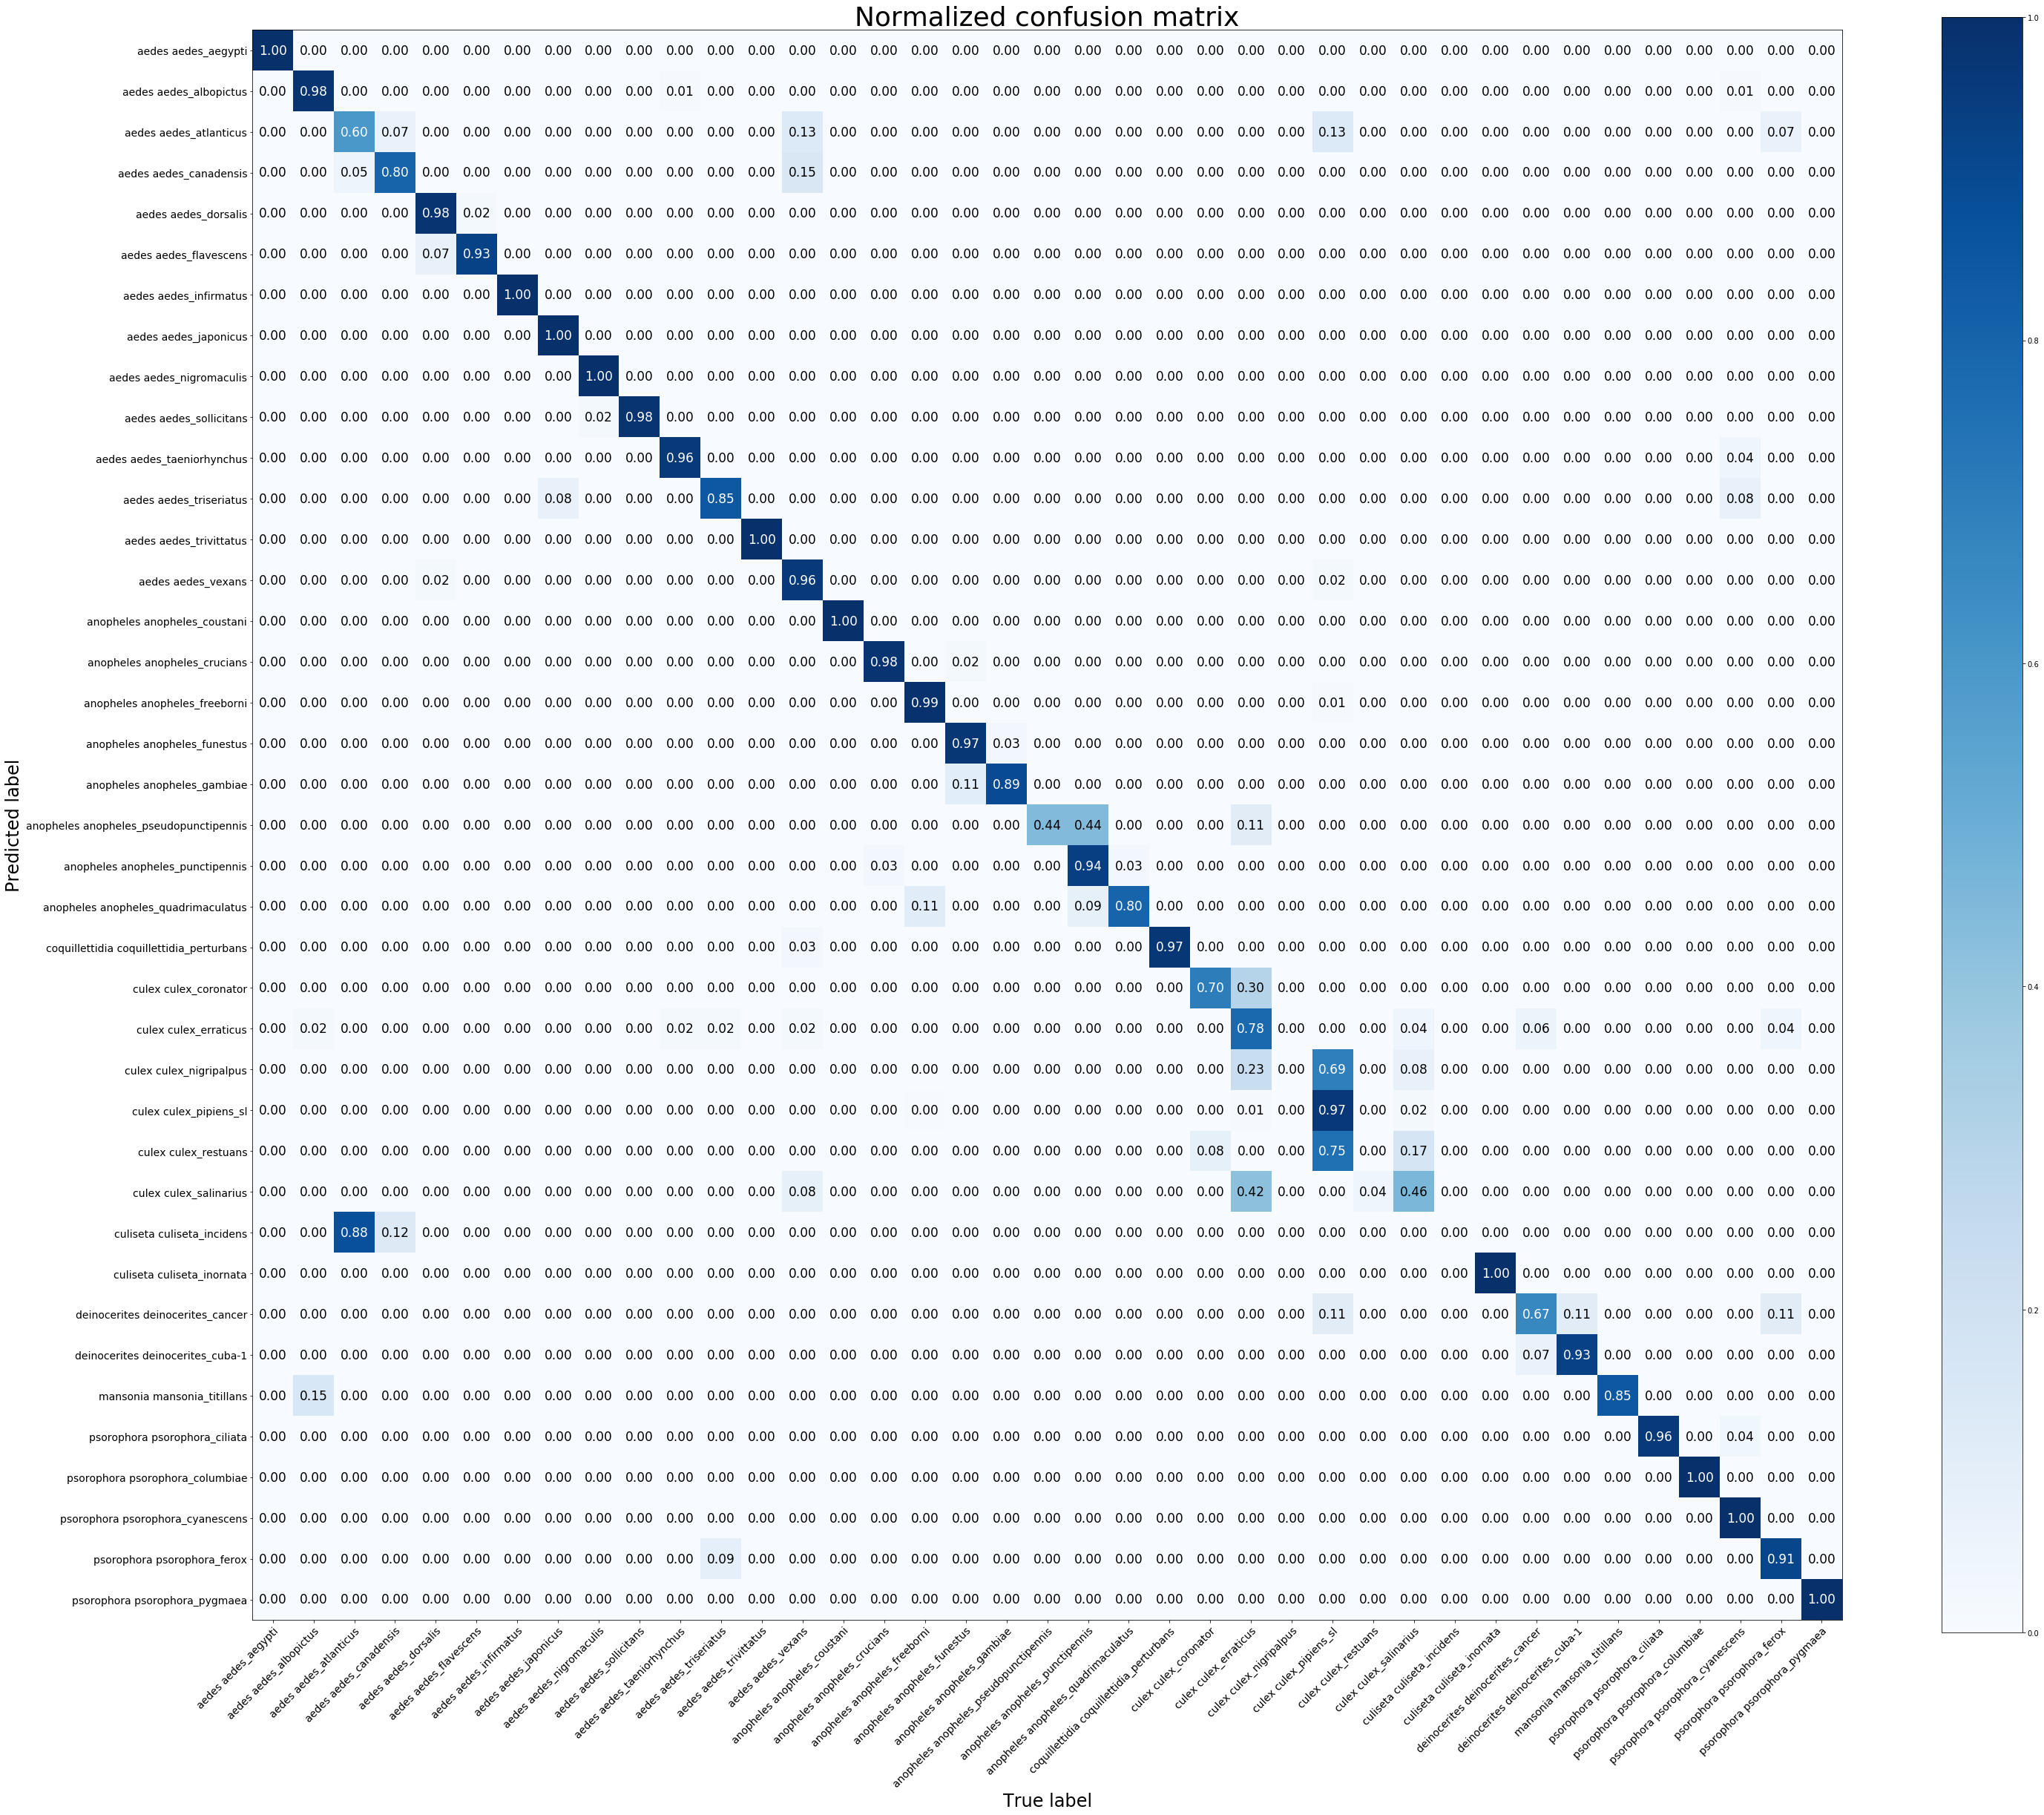

In [12]:
# from post_plots import plot_pretty_blue_confusion_matrix 
plot_pretty_blue_confusion_matrix(subm['Species'], subm['SpeciesPred'],
                      np.array([i[1] for i in config.class_map[:config.num_species.sum()]]), normalize=True,
                      savepath='./subm/{}/confusion_matrix.png'.format(config.exp_name))

## Generate Features & Probabilities for full dataset

In [24]:
%run test.py --full_df --metric acc --tta 1 --features --config 'configs/old_configs/paper_redo/fold5/config'

configs.old_configs.paper_redo.fold5.config

{'DATA_CSV_PATH': 'data/finale/datasplit_fold5.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes sollicitans'),
               (4, 'aedes aedes_taeniorhynchus'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_freeborni'),
               (8, 'anopheles anopheles_funestus'),
               (9, 'anopheles anopheles_gambiae'),
               (10, 'anopheles

In [25]:
%run test.py --full_df --metric acc --tta 1 --config 'configs/old_configs/paper_redo/fold5/config'

configs.old_configs.paper_redo.fold5.config

{'DATA_CSV_PATH': 'data/finale/datasplit_fold5.csv',
 'False_additions': False,
 'alpha': 0.99,
 'ann_start': 0.7,
 'augment_prob': 0.001,
 'batch_size': 16,
 'blend_params': {'alpha': 1.0,
                  'blend_type': 'cut',
                  'fixed_proba': 0,
                  'grid': True,
                  'same_crop': False,
                  'same_image': False,
                  'same_size': False,
                  'size': 0.15},
 'class_map': [(0, 'aedes aedes_aegypti'),
               (1, 'aedes aedes_albopictus'),
               (2, 'aedes aedes_dorsalis'),
               (3, 'aedes aedes sollicitans'),
               (4, 'aedes aedes_taeniorhynchus'),
               (5, 'aedes aedes_vexans'),
               (6, 'anopheles anopheles_coustani'),
               (7, 'anopheles anopheles_freeborni'),
               (8, 'anopheles anopheles_funestus'),
               (9, 'anopheles anopheles_gambiae'),
               (10, 'anopheles